# Location-scale regression

This tutorial implements a Bayesian location-scale regression model within the Liesel framework.
In contrast to the standard linear model with constant variance, the location-scale model allows for heteroscedasticity such that both the mean of the response variable as well as its variance depend on (possibly) different covariates.

This tutorial assumes a linear relationship between the expected value of the response and the regressors, whereas a logarithmic link is chosen for the standard deviation.
More specifically, we choose the model

$$
\begin{aligned}
y_i \sim \mathcal{N}_{} \left( \mathbf{x}_i^T \boldsymbol{\beta}, \exp \left( \mathbf{ z}_i^T \boldsymbol{\gamma} \right)^2 \right)
\end{aligned}
$$
in which the single observation are conditionally independent.

From the equation we see that *location* covariates are collected in the design matrix $\mathbf{X}$ and *scale* covariates are contained in the design matrix $\mathbf{ Z}$. Both matrices can, but generally do not have to, share common regressors.
We refer to $\boldsymbol{\beta}$ as location parameter and to $\boldsymbol{\gamma}$ as scale parameter.

In this notebook, both design matrices only contain one intercept and one regressor column.
However, the model design naturally generalizes to any (reasonable) number of covariates.


In [26]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.numpy.bijectors as tfb

sns.set_theme(style="whitegrid")

First lets generate the data according to the model

In [27]:
key = jax.random.PRNGKey(13)

In [28]:
n = 500

key, key_X, key_Z = jax.random.split(key, 3)

true_beta = jnp.array([1.0, 3.0])
true_gamma = jnp.array([0.0, 0.5])

X_mat = jnp.column_stack([jnp.ones(n), tfd.Uniform(low=0., high=5.).sample(n, seed=key_X)])
Z_mat = jnp.column_stack([jnp.ones(n), tfd.Normal(loc=2., scale=1.).sample(n, seed=key_Z)])

y_vec = jnp.zeros(n)
key_y = jax.random.split(key, n)

y_vec = jax.vmap(
    lambda x, beta, z, gamma, key: tfd.Normal(loc=x @ beta, scale=jnp.exp(z @ gamma)).sample(seed=key), 
    (0, None, 0, None, 0))(X_mat, true_beta, Z_mat, true_gamma, key_y)

The simulated data displays a linear relationship between the response $\mathbf{y}$ and the covariate $\mathbf{x}$.
The slope of the estimated regression line is close to the true $\beta_1 = 3$.
The right plot shows the relationship between $\mathbf{y}$ and the scale covariate vector $\mathbf{z}$.
Larger values of $\mathbf{ z}$ lead to a larger variance of the response.

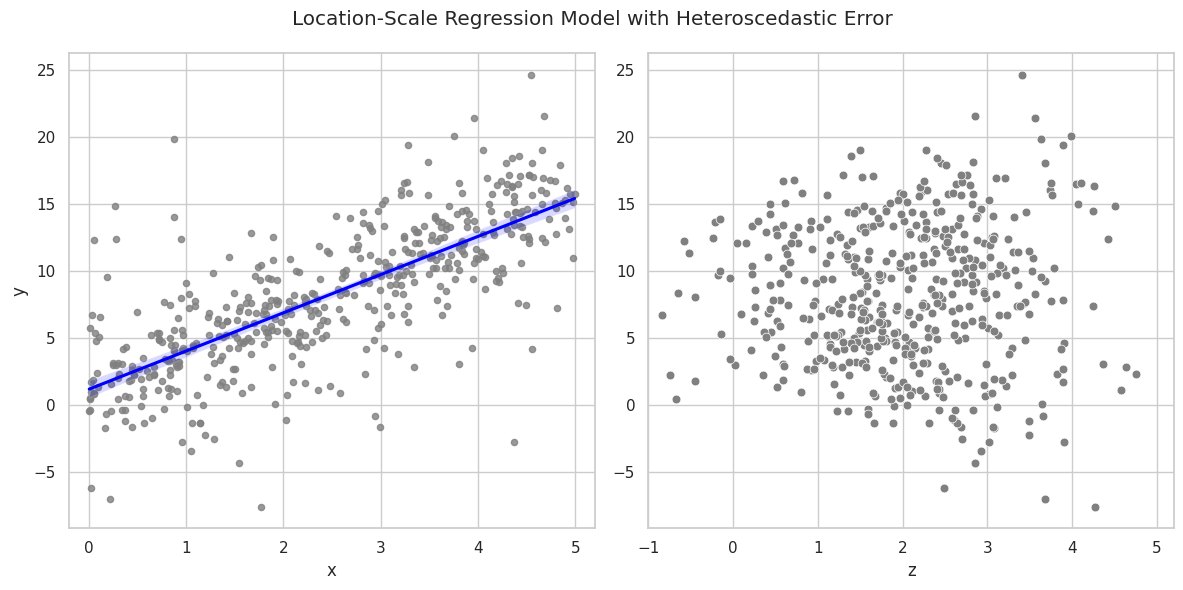

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.regplot(
    x=X_mat[:, 1],
    y=y_vec,
    fit_reg=True,
    scatter_kws=dict(color="grey", s=20),
    line_kws=dict(color="blue"),
    ax=ax1,
).set(xlabel="x", ylabel="y", xlim=[-0.2, 5.2])

sns.scatterplot(
    x=Z_mat[:, 1],
    y=y_vec,
    color="grey",
    s=40,
    ax=ax2,
).set(xlabel="z", xlim=[-1, 5.2])

fig.suptitle("Location-Scale Regression Model with Heteroscedastic Error")
fig.tight_layout()
plt.show()

Since positivity of the variance is ensured by the exponential function, the linear part $\mathbf{z}_i^T \boldsymbol{\gamma}$ is not restricted to the positive real line.
Hence, setting a normal prior distribution for $\gamma$ is feasible, leading to an almost symmetric specification of the location and scale parts of the model.
The variables `beta` and `gamma` are initialized with values far away from zero to support a stable sampling process:

In [30]:
beta_loc = lsl.Var(0.0, name="beta_loc")
beta_scale = lsl.Var(100.0, name="beta_scale")

dist_beta = lsl.Dist(
    distribution=tfd.Normal, loc=beta_loc, scale=beta_scale
)
dist_beta = lsl.Dist(tfd.Normal, loc=beta_loc, scale=beta_scale)

beta = lsl.Param(
    value=jnp.array([10., 10.]), distribution=dist_beta, name="beta"
)

In [31]:
gamma_loc = lsl.Var(0.0, name="gamma_loc")
gamma_scale = lsl.Var(3.0, name="gamma_scale")

dist_gamma = lsl.Dist(
    distribution=tfd.Normal, loc=gamma_loc, scale=gamma_scale
)
gamma = lsl.Param(
    value=jnp.array([5.0, 5.0]), distribution=dist_gamma, name="gamma"
)

The additional complexity of the location-scale model compared to the standard linear model is handled in the next step.
Since `gamma` takes values on the whole real line, but the response variable `y` expects a positive scale input, we need to apply the exponential function to the linear predictor to ensure positivity.

In [32]:
X = lsl.Obs(value=X_mat, name="X")
Z = lsl.Obs(value=Z_mat, name="Z")

mu = lsl.Var(lsl.Calc(lambda X, beta: X @ beta, X, beta), name="mu")
scale = lsl.Var(lsl.Calc(lambda Z, gamma: jnp.exp(Z @ gamma), Z, gamma), name="scale")

dist_y = lsl.Dist(distribution=tfd.Normal, loc=mu, scale=scale)
y = lsl.Obs(value=y_vec, distribution=dist_y, name="y")

We can now combine the nodes in a model and visualize it

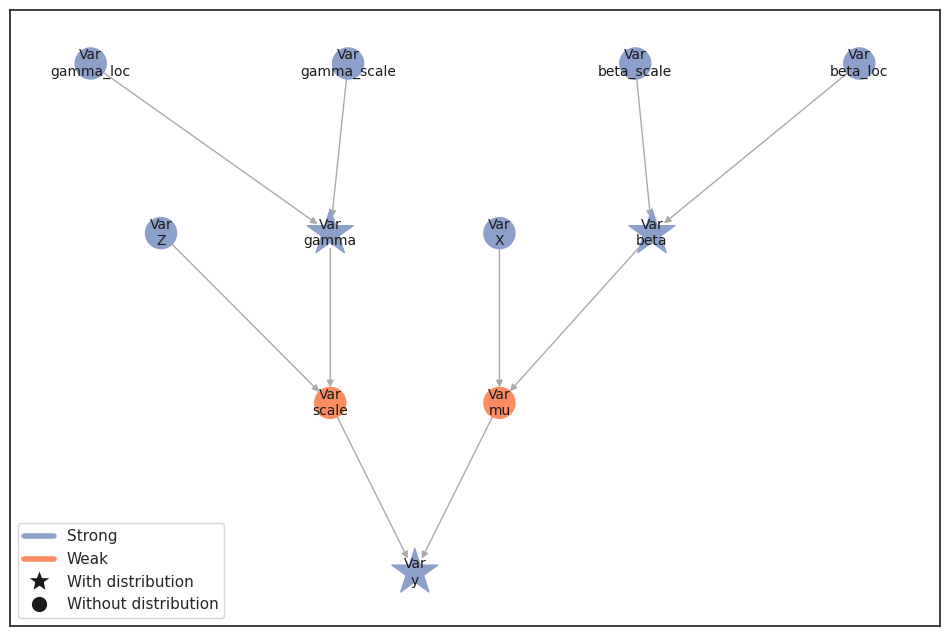

In [33]:
sns.set_theme(style="white")

gb = lsl.GraphBuilder()
gb.add(y)
model = gb.build_model() # builds the model from the graph (PGMs)

lsl.plot_vars(model=model, width=12, height=8)

We choose the No U-Turn sampler for generating posterior samples.
Therefore the location and scale parameters can be drawn by separate NUTS kernels, or, if all remaining inputs to the kernel coincide, by one common kernel.
The latter option might lead to better estimation results but lacks the flexibility to e.g. choose different step sizes during the sampling process.

However, we will just fuse everything into one kernel do not use any specific arguments and hope that the default warmup scheme (similar to the warmup used in STAN) will do the trick.

In [34]:
builder = gs.EngineBuilder(seed=73, num_chains=4)

# connects the engine with the model
builder.set_model(lsl.GooseModel(model))

# we use the same initial values for all chains
builder.set_initial_values(model.state)

# add the kernel
builder.add_kernel(gs.NUTSKernel(["beta", "gamma"]))

# set number of iterations in warmup and posterior
builder.set_duration(warmup_duration=1500, posterior_duration=1000, term_duration=500)

# create the engine
engine = builder.build()

# generate samples
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 5, 8, 6, 11 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 2, 2, 1 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 2, 1, 3, 1 / 50 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 100 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 2, 4, 5, 1 / 100 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 200

Now that we have 1000 posterior samples per chain, we can check the results. Starting with the trace plots just using one chain.

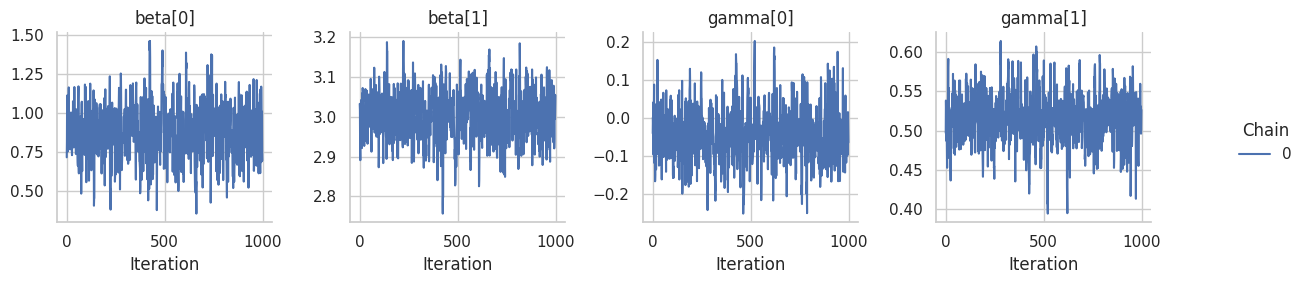

In [35]:
results = engine.get_results()
g = gs.plot_trace(results, chain_indices=0, ncol=4)

Looks decent although we can see some correlation in the tracplots. Let's check at the combined summary:

In [11]:
gs.summary_m.Summary(results, per_chain=False)

Parameter summary:

                      kernel      mean        sd    q_0.05     q_0.5  \
parameter   index                                                      
beta_value  (0,)   kernel_00  0.876359  0.182359  0.578095  0.875652   
            (1,)   kernel_00  3.003272  0.064367  2.896432  3.003431   
gamma_value (0,)   kernel_00 -0.046755  0.070785 -0.162619 -0.046261   
            (1,)   kernel_00  0.516990  0.031337  0.464891  0.516950   

                     q_0.95  sample_size     ess_bulk     ess_tail      rhat  
parameter   index                                                             
beta_value  (0,)   1.179883         4000  1490.187132  1609.617736  1.004499  
            (1,)   3.106861         4000  1541.591516  1748.091820  1.003861  
gamma_value (0,)   0.071415         4000  1656.387497  1667.515218  1.001693  
            (1,)   0.568095         4000  1683.444058  1799.057662  1.001369  

Error summary:

                                                    count  relative
kernel    error_code error_msg            phase                    
kernel_00 1          divergent transition warmup      105    0.0175
                                          posterior     0    0.0000

Maybe a longer warm-up would give us better samples.

In [12]:
builder = gs.EngineBuilder(seed=3, num_chains=4)

# connects the engine with the model
builder.set_model(lsl.GooseModel(model))

# we use the same initial values for all chains
builder.set_initial_values(model.state)

# add the kernel
builder.add_kernel(gs.NUTSKernel(["beta", "gamma"]))

# set number of iterations in warmup and posterior
builder.set_duration(warmup_duration=4000, posterior_duration=1000, term_duration=1000)

# create the engine
engine = builder.build()

# generate samples
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 7, 9, 8, 12 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 2, 2, 2, 2 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 1, 0, 4 / 50 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 100 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 2, 1, 2, 1 / 100 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 200

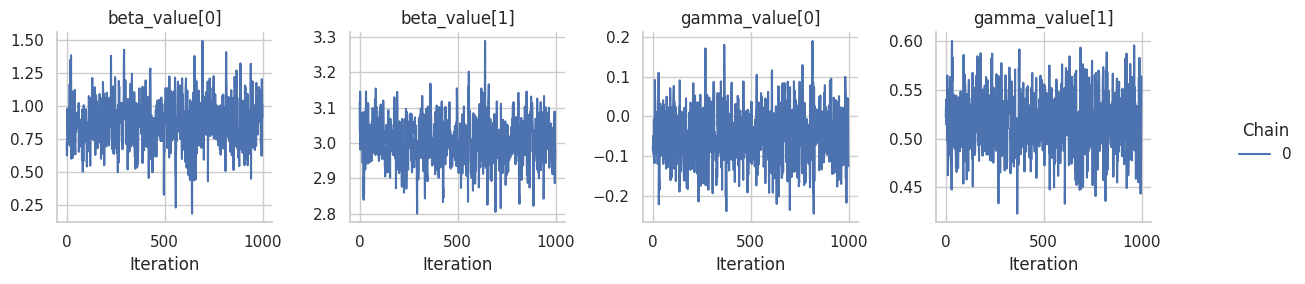

In [13]:
results = engine.get_results()
g = gs.plot_trace(results, chain_indices=0, ncol=4)

In [14]:
gs.summary_m.Summary(results, per_chain=False)

Parameter summary:

                      kernel      mean        sd    q_0.05     q_0.5  \
parameter   index                                                      
beta_value  (0,)   kernel_00  0.879413  0.175946  0.602185  0.879076   
            (1,)   kernel_00  3.002157  0.062228  2.899437  3.002958   
gamma_value (0,)   kernel_00 -0.044286  0.070380 -0.160068 -0.043388   
            (1,)   kernel_00  0.515594  0.030884  0.465932  0.515781   

                     q_0.95  sample_size     ess_bulk     ess_tail      rhat  
parameter   index                                                             
beta_value  (0,)   1.179214         4000  1958.483798  1595.243382  1.002497  
            (1,)   3.101426         4000  1920.829701  1702.274846  1.004097  
gamma_value (0,)   0.071281         4000  2162.576014  1976.343322  1.002621  
            (1,)   0.567025         4000  2223.678383  2048.002286  1.002293  

Error summary:

                                                    count  relative
kernel    error_code error_msg            phase                    
kernel_00 1          divergent transition warmup      130  0.008125
                                          posterior     0  0.000000

The trace plots for $\boldsymbol{\gamma}$ improved but those for $\boldsymbol{\beta}$ still show some corelation.